In [1]:
from pyFRF import FRF
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pyExSi

# Showcase of the package ``pyFRF``

The inputs are time signals of excitation and response, the outputs are FRF estimators (H1, H2, Hv or ODS) and coherence.

## Synthetic data example

Define a synthetic 3 DOF system and obtain its true FRF matrix from system properties:

In [2]:
# degrees of freedom:
ndof = 3

# mass matrix:
m = 2
M = np.zeros((ndof, ndof))
np.fill_diagonal(M, m)

# stiffness matrix:
k = 4000000
K = np.zeros((ndof, ndof))

for i in range(K.shape[0] - 1):
    K[i,i] = 2*k
    K[i+1,i] = -k
    K[i,i+1] = -k
K[ndof-1,ndof-1] = k

# damping matrix:
c = 50
C = np.zeros((ndof, ndof))

for i in range(C.shape[0] - 1):
    C[i,i] = 2*c
    C[i+1,i] = -c
    C[i,i+1] = -c
C[ndof-1,ndof-1] = c

# eigenfrequencies:
eig_val, eig_vec = scipy.linalg.eigh(K, M)
eig_val.sort()
eig_omega = np.sqrt(np.abs(np.real(eig_val)))
eig_freq = eig_omega / (2 * np.pi)

# frequencies:
df = 0.5
freq_syn = np.arange(0.0, 2000, df)
omega = 2 * np.pi * freq_syn

# time:
T = 1 / (freq_syn[1] - freq_syn[0])
dt = 1 / (2*freq_syn[-1])
t = np.linspace(0, T, 2*len(freq_syn)-2)

# synthetic FRF matrix of the system:
FRF_matrix = np.zeros([M.shape[0], M.shape[0], len(freq_syn)], dtype="complex128")  # full system 3x3 FRF matrix
for i, omega_i in enumerate(omega):
    FRF_matrix[:,:,i] = scipy.linalg.inv(K - omega_i**2 * M + 1j*omega_i*C)

For the first example we will focus on the first DOF of the system and simulate SISO (single input, single output) system:

In [3]:
# for the synthetic example in this showcase, we focus on the first DOF:
H1_syn = FRF_matrix[0,0,:]

Plot the selected synthetic FRF of the system:

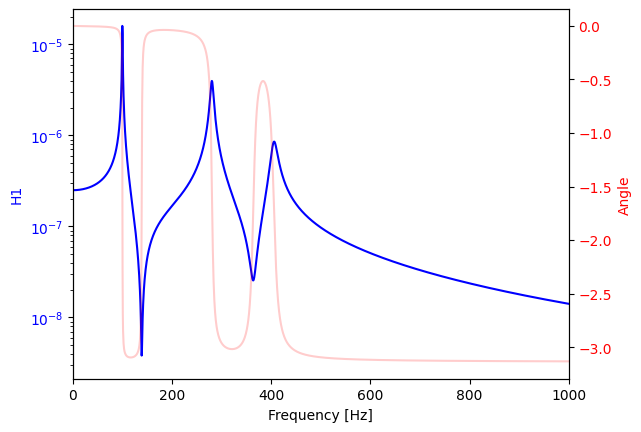

In [4]:
fig, ax1 = plt.subplots()

ax1.semilogy(freq_syn, np.abs(H1_syn), 'b')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('H1', color='b')
ax1.set_xlim(left=0, right=1000)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(freq_syn, np.angle(H1_syn), 'r', alpha=0.2)
ax2.set_ylabel('Angle', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

Define excitation signal (impulse) and obtain response signla (for impulse response that is the inverse FFT of the FRF):

In [5]:
# impulse:
exc = np.zeros_like(t)
exc[0] = 1

# impulse response:
resp = np.fft.irfft(H1_syn)

Plot the excitation and response signals:

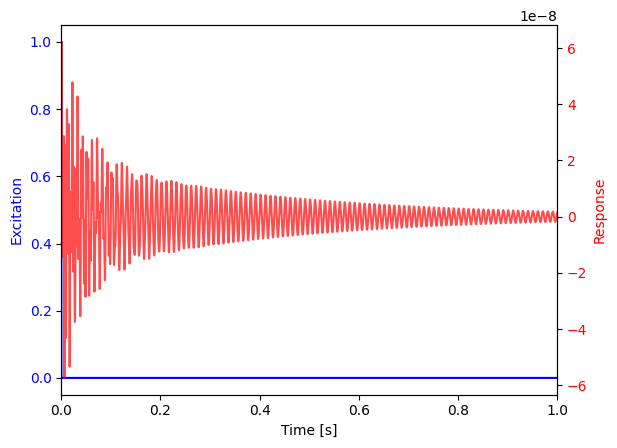

In [6]:
fig, ax1 = plt.subplots()

ax1.plot(t, exc, 'b');
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Excitation', color='b')
ax1.set_xlim(left=0, right=1)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(t, resp, 'r', alpha=0.7)
ax2.set_ylabel('Response', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

Creating the FRF object and getting the requested FRF estimator and frequency series:

In [7]:
# create an object
frf_object = FRF(sampling_freq=int(1/t[1]), exc=exc, resp=resp, resp_type='d')

# get frf
H1_pyFRF = frf_object.get_FRF()  # returns the requested FRF estimator matrix of shape (response DOF, excitation DOF, frequency points)
freq_pyFRF= frf_object.get_f_axis()  # returns frequency series
H1_pyFRF.shape  # single input, single output (SISO) system

(1, 1, 4000)

Comparison of the synthetic FRF and FRF obtained via pyFRF:

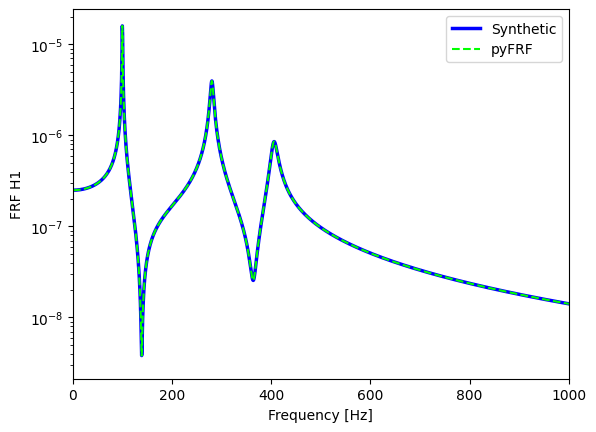

In [8]:
plt.semilogy(freq_syn[1:], np.abs(H1_syn)[1:], "b", label='Synthetic', lw=2.5)
plt.semilogy(freq_pyFRF[1:], np.abs(H1_pyFRF)[0,0,1:], "--", color="lime", label='pyFRF')
plt.xlim(left=0, right=1000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('FRF H1')
plt.legend();

Different available forms of the FRF:

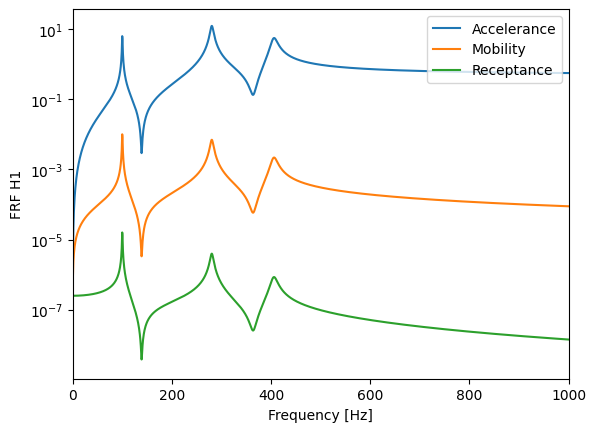

In [9]:
plt.semilogy(freq_pyFRF[1:], np.abs(frf_object.get_FRF(form='accelerance'))[0,0,1:], label='Accelerance')
plt.semilogy(freq_pyFRF[1:], np.abs(frf_object.get_FRF(form='mobility'))[0,0,1:], label='Mobility')
plt.semilogy(freq_pyFRF[1:], np.abs(frf_object.get_FRF(form='receptance'))[0,0,1:], label='Receptance')
plt.xlim(left=0, right=1000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('FRF H1')
plt.legend(loc=1);

## Multiple measurements with noise

#### Continuous measurements - ``add_data`` method

Specifying the number of measurements and creating the FRF object without passing the excitation and response signals:

In [16]:
n_measurements = 10
frf_object = FRF(sampling_freq=int(1/t[1]), fft_len=len(resp), resp_type='d', weighting='linear')

Adding noise to our response measurements and continuously adding data to our FRF object via ```add_data``` method:

In [17]:
k = 0.1 # rate of noise
for i in range(n_measurements):
    noise = k * (np.random.rand(len(resp))-0.5) * np.std(resp)
    frf_object.add_data(exc, resp+noise)

Comparison of the synthetic FRF and averaged FRF obtained via pyFRF:

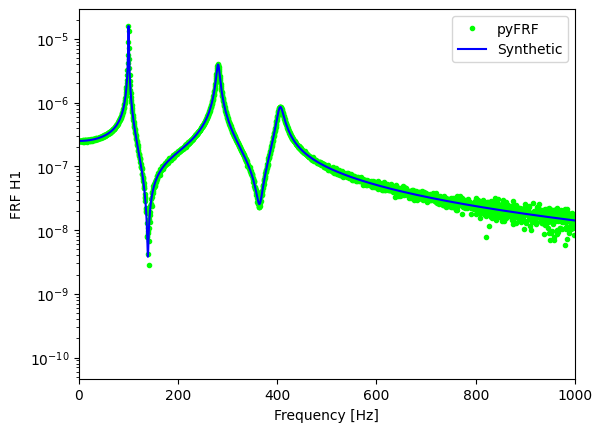

In [18]:
plt.semilogy(frf_object.get_f_axis()[1:], np.abs(frf_object.get_H1())[0,0,1:], '.', color="lime", label='pyFRF')
plt.semilogy(freq_syn, np.abs(H1_syn), "b", label='Synthetic')
plt.xlim(left=0, right=1000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('FRF H1')
plt.legend();

#### Adding all measurements at once at object creation

To avoid adding data via ```for``` loop, we can add all data at once (passing it at object creation or with ```add_data``` method) as array with shape (number of measurements, response/excitation time series):

In [19]:
n_measurements = 10
k = 0.1 # rate of noise
resp_mult_meas = np.empty(shape=(n_measurements, len(resp)))
exc_mult_meas = np.empty(shape=(n_measurements, len(exc)))

for i in range(n_measurements):
    noise = k * (np.random.rand(len(resp))-0.5) * np.std(resp)
    resp_mult_meas[i] = resp + noise  # array shape: (n_measurements, time series)
    exc_mult_meas[i] = exc  # array shape: (n_measurements, time series)

# pass the excitation and response arrays with all measurements at object creation:
frf_object = FRF(sampling_freq=int(1/t[1]), exc=exc_mult_meas, resp=resp_mult_meas, fft_len=len(resp), resp_type='d', weighting='linear')

Comparison of the synthetic FRF and averaged FRF obtained via pyFRF. We get the same result as in the previous example where we added data continuously:

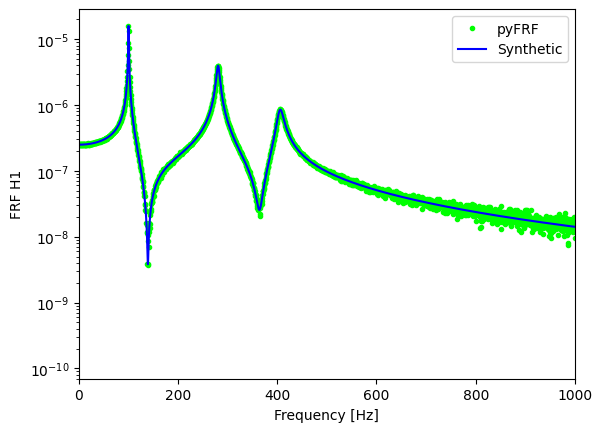

In [20]:
plt.semilogy(frf_object.get_f_axis()[1:], np.abs(frf_object.get_H1())[0,0,1:], '.', color="lime", label='pyFRF')
plt.semilogy(freq_syn, np.abs(H1_syn), "b", label='Synthetic')
plt.xlim(left=0, right=1000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('FRF H1')
plt.legend();

## Averaging multiple separate measurements with double impact and overflow detection

If required, please install ```lvm_read```:

In [21]:
#!pip install lvm_read

In [22]:
import lvm_read

Read the LabView measurement file:

In [23]:
measurement_filename = './data/impact2_response0.lvm'
measurement_file = lvm_read.read(measurement_filename)

Look at the LabView Measurement File:

In [24]:
measurement_file.keys()

dict_keys(['Decimal_Separator', 'Writer_Version', 'Reader_Version', 'Separator', 'Multi_Headings', 'X_Columns', 'Time_Pref', 'Operator', 'Date', 'Time', 0, 1, 2, 3, 4, 'Segments'])

There a several segments in this file (repetitions of measurements at particular excitation/response location):

In [25]:
measurement_file['Segments']

5

The first repetition is:

In [26]:
measurement_file[0].keys()

dict_keys(['Channels', 'Samples', 'Date', 'Time', 'Y_Unit_Label', 'X_Dimension', 'X0', 'Delta_X', 'data', 'Channel names'])

Lets check the data of segment 1:

In [27]:
segment = 1
measurement_file[segment]['Channel names']

['Force (Trigger)', 'Acceleration (Trigger)', 'Comment']

In [28]:
force = measurement_file[segment]['data'][:,0]
acceleration = measurement_file[segment]['data'][:,1]
dt = measurement_file[segment]['Delta_X'][0]
time = dt*np.arange(len(force))

Plot the force and the acceleration time series:

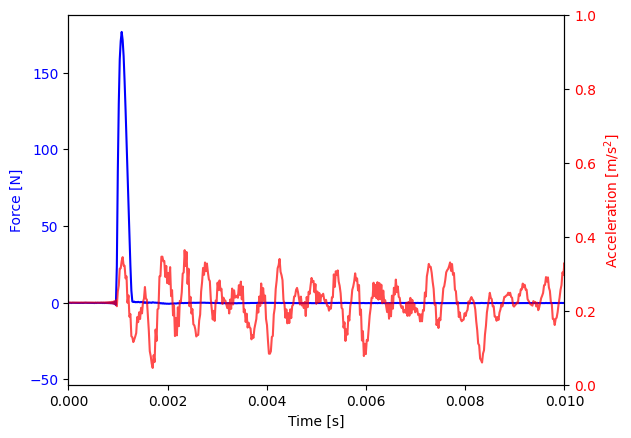

In [29]:
fig, ax1 = plt.subplots()

ax1.plot(time, force, label='Force', color='b');
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Force [N]', color='b')
ax1.set_xlim(left=0, right=0.002)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax1.plot(time, acceleration, label='Force', color='r', alpha=0.7);
ax2.set_ylabel('Acceleration [m/s$^2$]', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax1.set_xlim(0, 0.01);

Now we have to prepare the FRF object to be fed with impact measurements:

In [32]:
n_measurements = measurement_file['Segments']  # 5

frf_meas = FRF(sampling_freq=int(1/dt), 
               fft_len=len(force),
               window=('force:0.03', 'exponential:0.01'), 
               weighting='linear')

Add data with ```for``` loop. We dont take into account the data which is not ok (overflow, double impacts):

In [33]:
i = 0
for segment in range(n_measurements):
    force = measurement_file[segment]['data'][:,0]
    acceleration = measurement_file[segment]['data'][:,1]
    if frf_meas.is_data_ok(exc=force, resp=acceleration, overflow_samples=3, double_impact_limit=1e-3):  # if True - data is ok
        frf_meas.add_data(exc=force, resp=acceleration)
        i+=1
    else:
        print(f'Overflow or double-impact identified at segment: {segment}. This segment was not added.')

Overflow or double-impact identified at segment: 0. This segment was not added.
Overflow or double-impact identified at segment: 2. This segment was not added.


We can now check the segment 0 (this data was manually overflowed) and segment 2 (data with double impact):

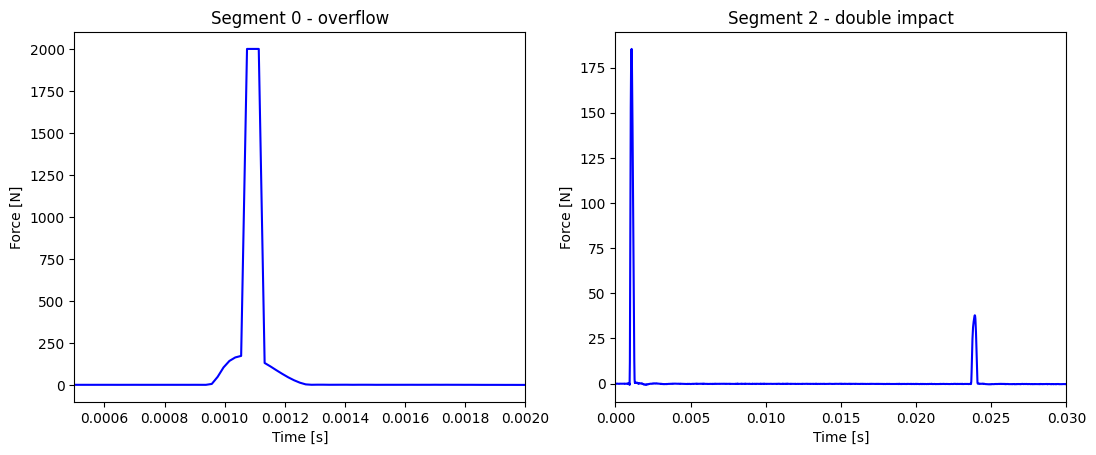

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))

segment = 0
force = measurement_file[segment]['data'][:,0]
time = dt*np.arange(len(force))
axs[0].plot(time, force, 'b')
axs[0].set_xlim(5e-4,20e-4)
axs[0].set_title(f'Segment {segment} - overflow')
axs[0].set_ylabel("Force [N]")
axs[0].set_xlabel("Time [s]");

segment = 2
force = measurement_file[segment]['data'][:,0]
time = dt*np.arange(len(force))
axs[1].plot(time, force, 'b')
axs[1].set_xlim(0,30e-3)
axs[1].set_title(f'Segment {segment} - double impact')
axs[1].set_ylabel("Force [N]")
axs[1].set_xlabel("Time [s]");

Resulting averaged FRF:

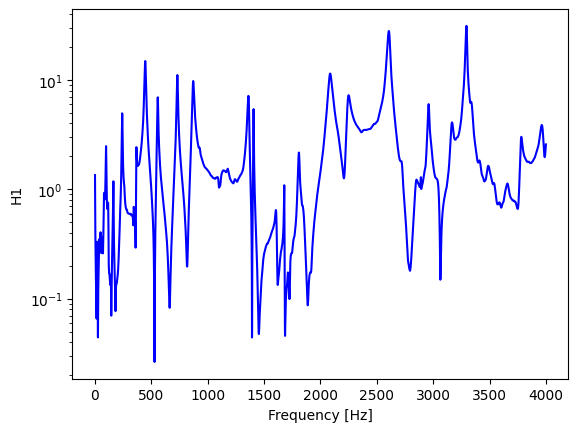

In [35]:
plot_up_to = 4000
plt.semilogy(frf_meas.get_f_axis()[1:plot_up_to], np.abs(frf_meas.get_FRF(form='accelerance'))[0,0,1:plot_up_to], "b")
plt.xlabel('Frequency [Hz]')
plt.ylabel('H1');

Coherence:

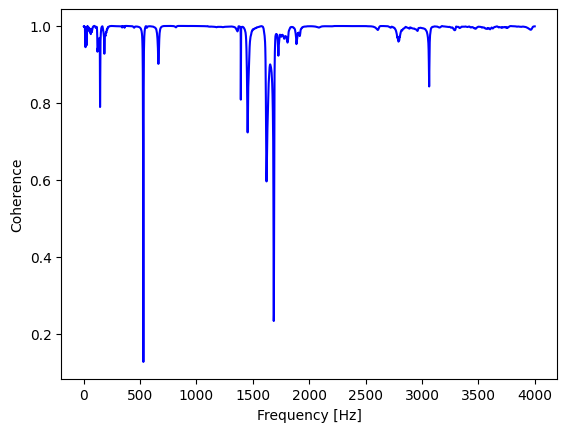

In [36]:
plt.plot(frf_meas.get_f_axis()[:plot_up_to], frf_meas.get_coherence()[0,:plot_up_to], 'b');
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence');

## MIMO systems and averaging

Define a MIMO (multiple input, multiple output) system (system from the beginning). System has 5 separate measurements where each DOF is excited with random excitation signal, generated with ```pyExSi``` package. Synthetic response is obtined from synthetic FRF matrix of the defined 3 DOF system.

Define excitation signals:

In [37]:
n_measurements = 5
exc_dofs = [0,1,2]  # all DOFs are excited with random signals

# preapare the exciatation array:
exc = np.zeros((n_measurements, len(exc_dofs), t.shape[0]))

for i in range(exc.shape[0]):
    for j in range(exc.shape[1]):
        exc[i][j] = 100 * pyExSi.normal_random(N=t.shape[0])  # normally distributed random signals

Obtain response:

In [38]:
resp_dofs = [0,1,2]  # response DOFs

EXC = np.fft.rfft(exc)
RESP = np.zeros((EXC.shape[0], FRF_matrix.shape[0], FRF_matrix.shape[2]), dtype="complex128")

# synthetic response via true systems FRF matrix:
for i in range(EXC.shape[0]):
    for j in range(EXC.shape[2]):
        RESP[i,:,j] = FRF_matrix[:,exc_dofs,j] @ EXC[i,:,j]
                
resp = np.fft.irfft(RESP, n=2*(len(freq_syn)-1))
resp = resp[:,resp_dofs]

Excitation array is of shape (number of measurements, excitation DOFs, time points) and response array is of shape (number of measurements, response DOFs, time points).

Plot excitation and response signals for one of the measurement:

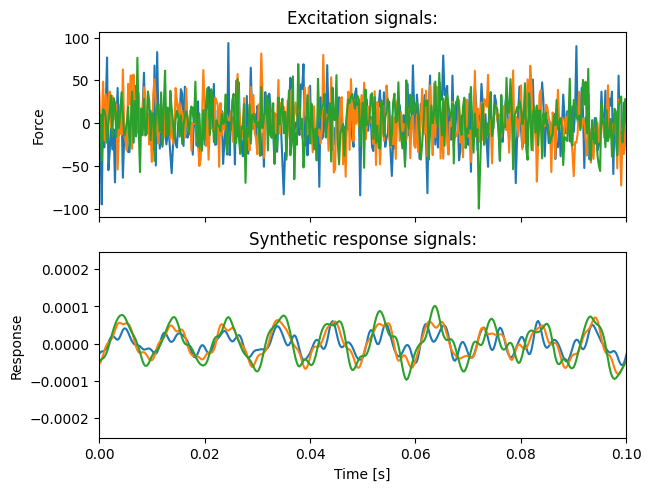

In [39]:
fig, axs = plt.subplots(2, 1, sharex=True, layout="constrained")

for i in range(1):
    for j in range(exc.shape[1]):
        axs[0].plot(t, exc[i,j], label="exc "+str(j))
        axs[0].set_xlim(left=0, right=0.1)
    
for i in range(1):
    for j in range(resp.shape[1]):
        axs[1].plot(t, resp[i,j], label="resp "+str(j))
    

axs[0].set_title("Excitation signals:")
axs[1].set_title("Synthetic response signals:")
axs[1].set_ylabel('Response')
axs[0].set_ylabel('Force')
axs[1].set_xlabel('Time [s]');

Define the FRF object with averaging settings - ``nperseg``, ``noverlap`` and ``window`` that is used when computing the cross power spectral density:

In [40]:
frf_MIMO_object = FRF(sampling_freq=int(1/t[1]), exc=exc, resp=resp, 
                      exc_type="f", resp_type="d", window="hann", 
                      nperseg=4000, noverlap=None, fft_len=None, 
                      frf_type="H1")

H1_pyFRF = frf_MIMO_object.get_H1()
freq_pyFRF = frf_MIMO_object.get_f_axis()

We obtain the full 3x3 FRF matrix of the MIMO system:

In [41]:
H1_pyFRF.shape

(3, 3, 4000)

Plot the full FRF matrix of the MIMO system compared with true FRF matrix of the system calculated at the beginning:

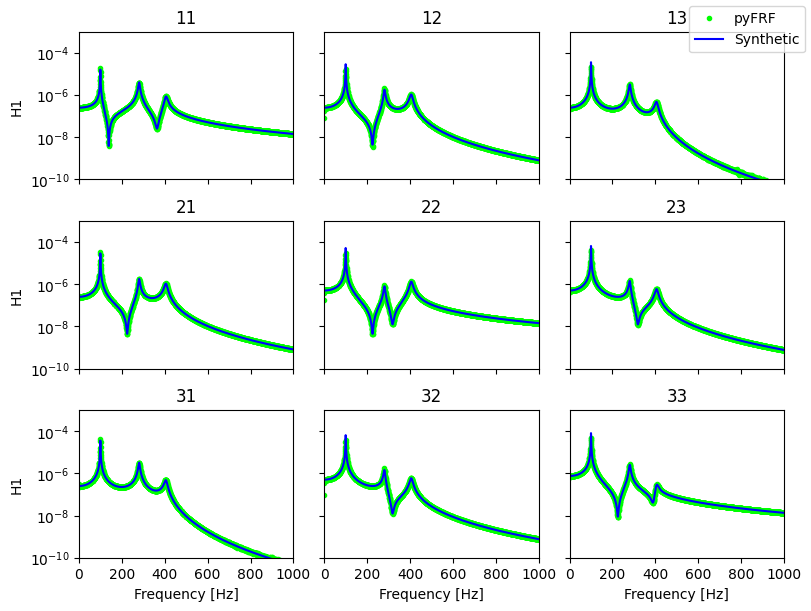

In [42]:
fig, axs = plt.subplots(FRF_matrix.shape[0], FRF_matrix.shape[1], figsize=(8,6), 
                        sharex=True, sharey=True, layout="constrained")

for i in range(H1_pyFRF.shape[0]):
    for j in range(H1_pyFRF.shape[1]):
        axs[resp_dofs[i],exc_dofs[j]].semilogy(freq_pyFRF, np.abs(H1_pyFRF[i,j,:]), 
                                               ".", color="lime", label="pyFRF")
     
for i in range(FRF_matrix.shape[0]):
    for j in range(FRF_matrix.shape[1]):
        axs[i,j].semilogy(freq_syn, np.abs(FRF_matrix[i,j,:]), "b", label="Synthetic")      
        axs[i,j].set_title(str(i+1)+str(j+1))
        axs[i,j].set_xlim(left=0, right=1000)
        axs[i,j].set_ylim(bottom=10e-11, top=10e-4)
        axs[FRF_matrix.shape[1]-1,j].set_xlabel("Frequency [Hz]")
    axs[i,0].set_ylabel("H1")
    
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc=1);